# Using a CNN to make a Sentiment Analyzer

Lets look at a Keras implementation of a sentiment analyzer which will assess sentences presented to it in terms of the degree to which they reflect positive or negative **sentiment**.

I've used an approach from the excellent book [Natural Language Processing In Action](https://www.manning.com/books/natural-language-processing-in-action) (1st Edition) by Hobson Lane et.al., and he in turn had used another excellent book [Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) (2nd Edition) by Aurelin Geron.


There is a number of goals here :


*   Developing fluency in accessing datasets that can be used with tools for NLP tasks
*   Familiarising you with an online processing environment, which can handle file, processing and memory overheads that may not be available to you locally - in the case we use **Colab** and **Google Drive**.
* Bridging machine learning concepts that you may have learned in other contexts (such as in image processing) to natural language processing
*   Familiarizing you with a neural network framework, in this case **Keras**.
*  Creating a CNN based AI application for Sentiment Analysis
* Providing concepts and issues that allow you to appreciate and understand benefits and developments of subsequent advanced NLP concepts and tools.



In [1]:
import numpy as np
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalMaxPooling1D

# Getting data into Colab

Also, we are going to use **Google Drive** with **Colab**, so we need to mount our Google Drive into the Colab file system. In order to do this you will need a Google Drive account and Google will ask your permission when you try to mount it.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Datasets
We are going to use two datasets in order to build our CNN for sentiment analysis.

* One dataset is a **collection of statements whose sentiments are identified as positive or negative** from Stanford AI which can be downloaded from [this link](https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz). This will be used to train the neural network that will identify new statements we present as positive or negative. The dataset was compiled for the 2011 paper [Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~amaas/papers/wvSent_acl2011.pdf).
* The Stanford AI dataset effectively provides a relationship between **sentiments** and **collections of words**, (although we have to determine what these relationships are in order to exploit them).
* The other dataset will provide us with a corpus to create a **word embedding** for our sentiment data. Remember that neural networks act on *numbers*, not *words*, so a conversion of word tokens into word vectors is necessary and this is performed through a word embedding. These are **[Word2vec vectors trained on Google News](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)** This provides a relationship between **collections of words** and **vectors**
* The combination ultimately provides us with a relationship between **collections of words** and **sentiments**.

In any case, if you put them on your Google Drive, you only need to do it once.

The code presented below is one of [many ways of getting the data into the Colab environment](https://towardsdatascience.com/importing-data-to-google-colab-the-clean-way-5ceef9e9e3c8).

I've kept it simple and haven't involved AWS, Docker or others at this point, although when working on corporate projects you will likely use such environments.

Uploading to Google Drive can take several minutes, but once you have put the data on Google Drive, it is only a matter of only a few seconds to access.

In [3]:
# Unzip the zipped file containing the sentiment data using the command gunzip
# The exclamation mark indicates that the command is being sent to the operating system and is not a Python command.
!gunzip '/content/drive/MyDrive/MSc NLP Files/aclImdb_v1.tar.gz'
!gunzip '/content/drive/MyDrive/MSc NLP Files/GoogleNews-vectors-negative300.bin.gz'

gzip: /content/drive/MyDrive/MSc NLP Files/aclImdb_v1.tar already exists; do you wish to overwrite (y or n)? ^C


and now extract the tarball into the Colab environment (look over at the Files section and you will now see an extracted directory call **aclImdb**

In [4]:
!tar -xvf '/content/drive/MyDrive/MSc NLP Files/aclImdb_v1.tar'
!tar -xvf '/content/drive/MyDrive/MSc NLP Files/GoogleNews-vectors-negative300.bin.gz'

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/44954_0.txt
aclImdb/train/unsup/44953_0.txt
aclImdb/train/unsup/4

In summary, find the files and download them, **gunzip** them and/or **tar** extract them in order to use them.
The Google News vectors can also be downloaded using the **wget** command.

*   Download the Word2vec vectors trained on Google News from [this link](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)
*   Upload this file to a folder on your Google Drive. This is good practice as in using Colab and Google Drive together.
*   Mount Google Drive in the Colab filesystem using the instructions [at this link](https://medium.com/ml-book/simplest-way-to-open-files-from-google-drive-in-google-colab-fae14810674) ensuring that you follow the details carefully.
*   Then you can access the file accordingly

## Preprocessing the data

Next let's preprocess the data. All downloaded data needs some cleaning so here we write a pre-processing routine that splits the the sentiments data into **positive** and **negative** sentiments.

As with all processing with neural networks, we need to represent data as numbers. So, we identify **positive** with **1** and **negative** with **0**.
Ultimately, we are going to get the system to predict sentiments of an input expression as a number between 0 and 1, with values closer to 0 being negative and closer to 1 being positive.

In [5]:
import glob
import os
from random import shuffle

def pre_process_data(filepath):
    """
    This is fairly generic code for sentiment analysis cleaning but
    it comes down to splitting the data into positive and negative
    sentiments and labelling it accordingly with target values for
    sentiment, 1 for positive and 0 for negative
    """
    positive_path = os.path.join(filepath, 'pos')
    negative_path = os.path.join(filepath, 'neg')
    pos_label = 1
    neg_label = 0
    dataset = []

    for filename in glob.glob(os.path.join(positive_path, '*.txt')):
        with open(filename, 'r') as f:
            dataset.append((pos_label, f.read()))

    for filename in glob.glob(os.path.join(negative_path, '*.txt')):
        with open(filename, 'r') as f:
            dataset.append((neg_label,f.read()))

    shuffle(dataset)

    return(dataset)

Lets apply this to our extracted data. As the intention here is to familiarize you with data in Colab for NLP purposes, look at the Files toolbar to the left and see that the directory structure should now contain a folder called **aclimdb**. Click into that directory and it should show you a folder called **train**. We want to pre-process the training data in that directory using our pre-processing routine. So **right-click** on that directory and select **Copy path** so that you can use that directory in the next piece of code; after you type **pre_process_data** below you can paste in the copied path as below.

In [6]:
dataset = pre_process_data('/content/aclImdb/train')

### What do the data look like?
So, what does it look like now? We can pick a random example, e.g., the 42nd entry, to see :

In [7]:
dataset[42]

(1,
 'Actor Herman José plays the role of a football of a soccer entrepreneur that acquires the pass of two African players and tries to sell them for very little money to the rival club of the Benfica (club of its heart),FC Porto, therefore these players did not play well, and it wanted that the FC Port was wronged with this. But what happens is that these two players after all are good and FC Porto sell them for much money to a foreign club, making a good business. The film, for a small country as Portugal, without great antecedents in great films, is a very good and funny comedy, showing all the rivalry that exists between North/South of Portugal (FC Porto/Benfica). Highly recommended')

Essentially, this consists of two elements, the first of which is the **target value** for the sentiment (**1** for **positive sentiment**, **0** for **negative sentiment**) and the second the **corresponding review comment** that expresses that sentiment.

# Tokenizing and vectorizing the data

Now that we have the data, we need to **tokenize** it and **vectorize** it. The tokenizing will be done using the Treebank Word Tokenizer from the Natural Language Toolkit **nltk**. The vectorizing will be done using Word2vec vectors that were trained on Google News.

In [8]:
# import nltk # This is the powerful Natural Language Toolkit (NLTK)
import gensim
from nltk.tokenize import TreebankWordTokenizer
from gensim.models.keyedvectors import KeyedVectors


Now provide the Google News trained tokens to the gensim word2vec. This can take a few minutes (it took my system 2 -3 minutes).

In [9]:
from gensim import models

w = models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/MSc NLP Files/GoogleNews-vectors-negative300.bin', limit = 20000, binary=True)


### Helper function for tokenizing and vectorizing
Again, we write a helper routine, this time for vectorization and tokenization. This is used to feed our data to the [Treebank Word Tokenizer](https://www.nltk.org/api/nltk.tokenize.treebank.html) and will return the tokens with their corresponding word vectors. The tokenizer will decompose the texts into tokens, handling punctuation, hyphenation and other language features.

So we
* **tokenize** the text corpus to extract valid tokens
* **vectorize** the tokens into an optimal form to train a network

In [10]:
def tokenize_and_vectorize(dataset):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    expected = []
    for sample in dataset:
        tokens = tokenizer.tokenize(sample[1])
        sample_vecs = []
        for token in tokens:
            try:
                sample_vecs.append(w[token])

            except KeyError:
                pass # No matching token in the downloaded Google word2vec vocab

        vectorized_data.append(sample_vecs)

    return vectorized_data

### Trade-offs in tokenization

This is engineering, so **there is always a trade-off** and information is going to be lost; if there are tokens in the IMDB database that are not in the Google News Word2vec vocabularly, in this case they are skipped.

This can be addressed in applications by retraining the word2vec vectors and even deliberately excluding "**junk**" from the data. Such junk could include superfluous text elements like **HTML tags**, or **bullets** or other such formatting elements that are not communicating any relevant information on the underlying text.

Terms that are deliberately excluded because they do not add value to the extraction of meaning (or because they remove value by contributing "noise" to the data) are called **stop-words**.

Next we need to collect the **target values** of the sentiments (the **ground-truth** sentiment labels associated with each review), so again, a helper function is written to facilitate this.

In [11]:
def collect_expected(dataset):
    """ Extract the target sentiments from the dataset """
    expected = []
    for sample in dataset:
        expected.append(sample[0])
    return expected

Now, just pass the data to the helper functions to be **tokenized** and **vectorized**. This takes typically about 30 seconds on Colab.

In [12]:
vectorized_data = tokenize_and_vectorize(dataset)
expected = collect_expected(dataset)

As a generally good practice, if we have a large body of data that we are not using, then we get rid of that data. This is both good housekeeping and stops Colab from complaining about **RAM** or **Disk** resource loading.

As a rule, keep an eye on the performance meter bar in the top right of the Colab environment when running code; if it occasionally goes yellow at any stage then review your code, as it may be overloading the system and your code might fail to run if there are any small changes to it or the runtime environment.

In [13]:
# When we no longer need the dataset, we delete it
# This is both good housekeeping and it stops
# Colab from complaining about RAM or disk overrun
del(dataset)

In [14]:
len(vectorized_data)

25000

### Splitting data into training and test sets
Next split the vectorized data into a training set and a test set; this can be done in one line of code, but for clarity it is broken out here. An 80/20 split for training/testing is common, so a split **0.8** along the data will be made.

In [15]:
split_point = int(len(vectorized_data)*.8)
x_train = vectorized_data[:split_point]
y_train = expected[:split_point]
x_test = vectorized_data[split_point:]
y_test = expected[split_point:]

In [16]:
len(x_train)

20000

Now, we apply a bit of good coding practice; since we've used the vectorized_data to create **x_train**, **y_train**, **x_test** and **y_test**, we no longer need it so we delete it. This is important to think about when using NLP applications; corpora can take up a lot of space and can do things like crash your **Colab session** or whatever system you are using.

In [17]:
del(vectorized_data) # Clear some more RAM!

## Tidying the input data
Next we have to **pad** or **truncate** the sequence of tokens in each review so that we have a fixed input length (**maxlen**) of tokens for our CNN input.

In [18]:
def pad_trunc(data, maximumlen):
    """
    Pad or truncate each review to the size set by the hyperparameter maxlen
    because we need all the inputs of the CNN to be of fixed size.
    """
    new_data = []

    zero_vector = []
    for _ in range(len(data[0][0])):
        zero_vector.append(0.0)

    for sample in data:
        if len(sample) > maximumlen: # if the input is too large, truncate it
            temp = sample[:maximumlen]
        elif len(sample) < maximumlen: # if the input is too small, pad it
            temp = sample
            # Append the appropriate number zero vectors to the list
            additional_elems = maximumlen - len(sample)
            for _ in range(additional_elems):
                temp.append(zero_vector)
        else:
            temp = sample
        new_data.append(temp)
    return new_data

### Numpy - efficient data structures

Now we need to apply this to the test and train data and we will have nice data structures of fixed size for inputting to the CNN.

As is generally the case in machine learning / data science, much of the work of the programmer is in pre-processing. Once the system is set up well, an environment like Keras will do the "heavy lifting" of large scale arithmetic operations.

Part of a good setup is to use efficient data structures with optimised operations and this is something that is provided by the Python library **NumPy**.

**NumPy tensors** are the data structures we try to use as they are easy for Keras to manipulate and are optimised *"under the hood"* for efficiency.

Beware however! In using Google Drive and Colab you will find that a lot of memory (RAM, scratch and otherwise) is needed. So you need to make sure that there is plenty of space on your Google Drive or your Colab session will fail. This is particularly the case when you use **np.reshape** of large arrays as below. This crashed a few times when I tried it without making sure that space was cleared by deleting unneeded data.

In [21]:
maxlen = 100
embedding_dims = 300
x_train = pad_trunc(x_train, maxlen)
x_test = pad_trunc(x_test, maxlen)   # Does the same with the test cases

x_train = np.reshape(x_train, (len(x_train), maxlen, embedding_dims))
y_train = np.array(y_train)

x_test = np.reshape(x_test, (len(x_test), maxlen, embedding_dims))
y_test = np.array(y_test)

In [22]:
len(x_train)

20000

You'll have noticed that data processing in general is front-loaded with pre-processing and the ability to do this is a key skill in AI / Machine Learning! It is the dirty little secret of this knowledge domain! But it is a significant differentiator.

# Tuning the network - Hyperparameters

Now, we consider the **hyperparameters** for the network. Hyperparameters are properties of a network architecture and/or learning method that can be pre-configured prior to creating and training a network.


*   **maxlen** holds the maximum review length. If a review is more than this length, it is truncated and if less it is padded to this length.
*   **batch_size** indicates how many samples to show the net before performing a backpropagation of error and updating the weights
*   **embedding_dims** is the length (number of rows) of the token column vector being passed into the CNN
*   **filters** is the number of filters that will be trained
*   **kernel_size** is the width of the filters; the filters will be matrices of weights and the size of these will be **embedding_dims** x **kernel_size**
*   **hidden_dims** is the number of neurons in the feedforward network at the end of the chain.
*   **epochs** is the number of times the entire training set is passed through the network



In [23]:
maxlen = maxlen
batch_size = 32
embedding_dims = embedding_dims
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

# Building the CNN

Now that the training data has a **word embedding** representation and has appropriately constant formatting of input data, we can make the network that we are going to feed the data into. The network will have several characteristics that are relevant.


*   We are going to make a **sequential** network, so the data will proceed sequentially from input to output.
*   We then add a **convolutional layer** as we are exploring CNNs in this case.
*   We will add some padding for the data flow, as the output has a dimension smaller than the inputs. Padding addresses incongruences in dimension sizes in the workflows.
*  The **stride** (the shift that each convolution moves by) is one token and the **kernel** itself is 3 wide.
*  We will use a simple **relu** activation function. This effectively means that when we apply a filter, if the filter value sums are greater than zero, we send them to the next layer or send zero otherwise.

This is easy to set up in Keras as in the code below.



In [24]:
# Let people know what you are doing
print('Build CNN model for our Advanced NLP course....')
model = Sequential()
model.add(Conv1D(
    filters,
    kernel_size,
    padding='valid',
    activation='relu',
    strides=1,
    input_shape=(maxlen, embedding_dims))
)
print('Model built')
model.summary()

Build CNN model for our Advanced NLP course....


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model built


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 98, 250)             │         225,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,250 (879.88 KB)

 Trainable params: 225,250 (879.88 KB)

 Non-trainable params: 0 (0.00 B)

### Pooling
We want to extract information from the network by reducing the dimensionality of the data, and extracting meaningful patterns from it. When this is done in image processing for example, typically **data that conveys information** is retained (e.g., data that relates to the presence of edges in an image) and data that does not convey additional useful information is discarded. In this NLP case, we are exploiting relationships that arise between words. So in this case, we can **pool** filter outputs, use a characteristic such as the **average** or **max** of those values, and then discard the filter outputs. The pooled characteristic will then **carry forward** the emerging meanings in the data.

For our purposes, we are trying to see features that stand out, so we will use **max pooling**; the principle here is the largest activation value for a given region is an indication of the most prominent "feature" in that region, so that is what we should capture with pooling.


In [25]:
model.add(GlobalMaxPooling1D())

Another nice property of pooling is that it can pick out a feature out of a pooling window regardless of where the feature is in that window. This is important in ***image processing*** because it means that features can be detected regardless of where they are in the image. In the same way, this **location invariance** can be exploited in NLP.

This has a downside however; not caring where a feature is in a window is the same as not caring where a word is in a sentence. That means that, potentially, the sentence "***The dog chases the cat.***" is considered the same as "***The cat chases the dog***".

However, it is important to realize that location invariance, is both a good and bad thing.

*   We want our learning system to tolerate "**noise**" (in the sense of **irrelevant** words or punctuation affecting the extraction of meaning)
*   However, we **do** want to exploit the general rule that "you can tell a word's meaning by the company it keeps"

So, as everything in engineering, there is a trade-off!
We have exploited word **proximity** but we have not exploited word **order**. We will return to this later when reviewing the architectures.


## Brief Recap - what have we done and how did we get there?

At this point, you have done the following :


1.   You have **collected input text data** along with a way of representing that data as **word vectors**.
2. Data preprocessing has been performed to bring **input data into a useful representation** for the network training
3. A **CNN model has been constructed** with basic filters
4. The model will exploit **max pooling** of the output of the filters to detect features
5. For each input example, a filter (weighted sum of elements followed by an activation function) is applied
6. After convolution across the input, you will get a slightly smaller output (since the filter window is quite narrow) of filter outputs
7. For each filter output, you took the single max value from each, leaving you with a vector of dimension (1 x *number of filters*). From the perspective of the network, this is a very interesting vector.

The vector is very interesting as it represents a crude **semantic** representation of the input with respect to the training objective of the network (sentiment) and in this way can be though of as a sort of **thought vector**. The concept of thought vectors is very useful when developing an **intution for the relationships between natural language processing and deep learning**.



### Avoiding overtraining using Dropout

Ok, so far so good, so now we want to make sure that the network during the learning process loses superfluous structure that does not necessarily promote the structure that allows the network to generalize to data outside of the training set. We don't want the network to be merely a **memory** of the training set and to be **overfitted**.

In order to do this, we exploit the technique of **dropout** ; the principle behind this is that a percentage of the inputs for subsequent layers are turned off and that this forces the network to learn from data in a more general way. Keras looks after this in our system. a commonly used value is dropouts of between 20% and 50%. Throwing out too much means that the network won't learn well and could be **underfitted** whereas throwing out too little means that the network remembers the training data, including superfluous characteristics, leading to bias and **overfitting**.

What is the "right" answer? As with most work in machine learning, ***there is no obvious right answer*** except to try and test various values.

In [26]:
model.add(Dense(hidden_dims)) # This is provides a fully connected hidden layer
model.add(Dropout(0.2)) # A dropout of 0.2 is added here
model.add(Activation('relu')) # The Rectified Linear Unit activation function is used here

### Final classification layer - Sigmoid function

Finally, we want to have an output that gives us a sense of degree of classification. When training sentiment, we used a value of **0** for **negative sentiment** and **1** for **positive sentiment** and would like an output that gives us an indicator between these two scales, so that we can get a sense of sentiment for a given input; the closer an output value is to 0 than to 1, the more negative the sentiment and the closer an output value is to 1 than to 0, the more positive the sentiment.

A useful activation function for this is the **sigmoid function** as it can squeeze any range of input values into a scaled proportionate representation between 0 and 1. That way, we get a stable output that represents the sentiment of the input.

We want this layer to be fed from all of the information propagating from the previous layer, so we add another dense layer and feed the output of this into a sigmoid activation function to get our output sentiment as a value between 0 and 1.

In [27]:
model.add(Dense(1)) # Add 1 dense layer
model.add(Activation('sigmoid')) # Apply a sigmoid to the output of that layer to take the output to between 0 and 1

### Compile the CNN

Now, lets compile the CNN. This just means making sure that the network we have built is ready to be trained with a particular loss function, that the training of the network is optimised in a particular way and that we can have some metric that tell us how the network is doing as we train it.

* We want to use a **loss function** that we minimize and in this case we use **binary crossentropy** ; the choice of loss functions is beyond the immediate scope of the application, however crossentropy in general is a good indicator of the disparity between what are data show and what our model predicts at that stage in the process.

* We **optimize** updating the loss function using one of several techniques, in this case ADAM.

* While we are doing so, we maintain a **metric** telling us about how the well the training is progressing with respect to the data. Ideally, the more we train the network with good input data, the more accurate the network will become at predicting the sentiment of validation data. So the metric we choose to track is **accuracy**.

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### What does the network "look" like?
Now we have a network built. So what does it look like? We can can use the **model.summary()** command and we can generate a simple graphic.

In [29]:
# Show a text based description of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 98, 250)             │         225,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 250)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             251 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 288,251 (1.10 MB)

 Trainable params: 288,251 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

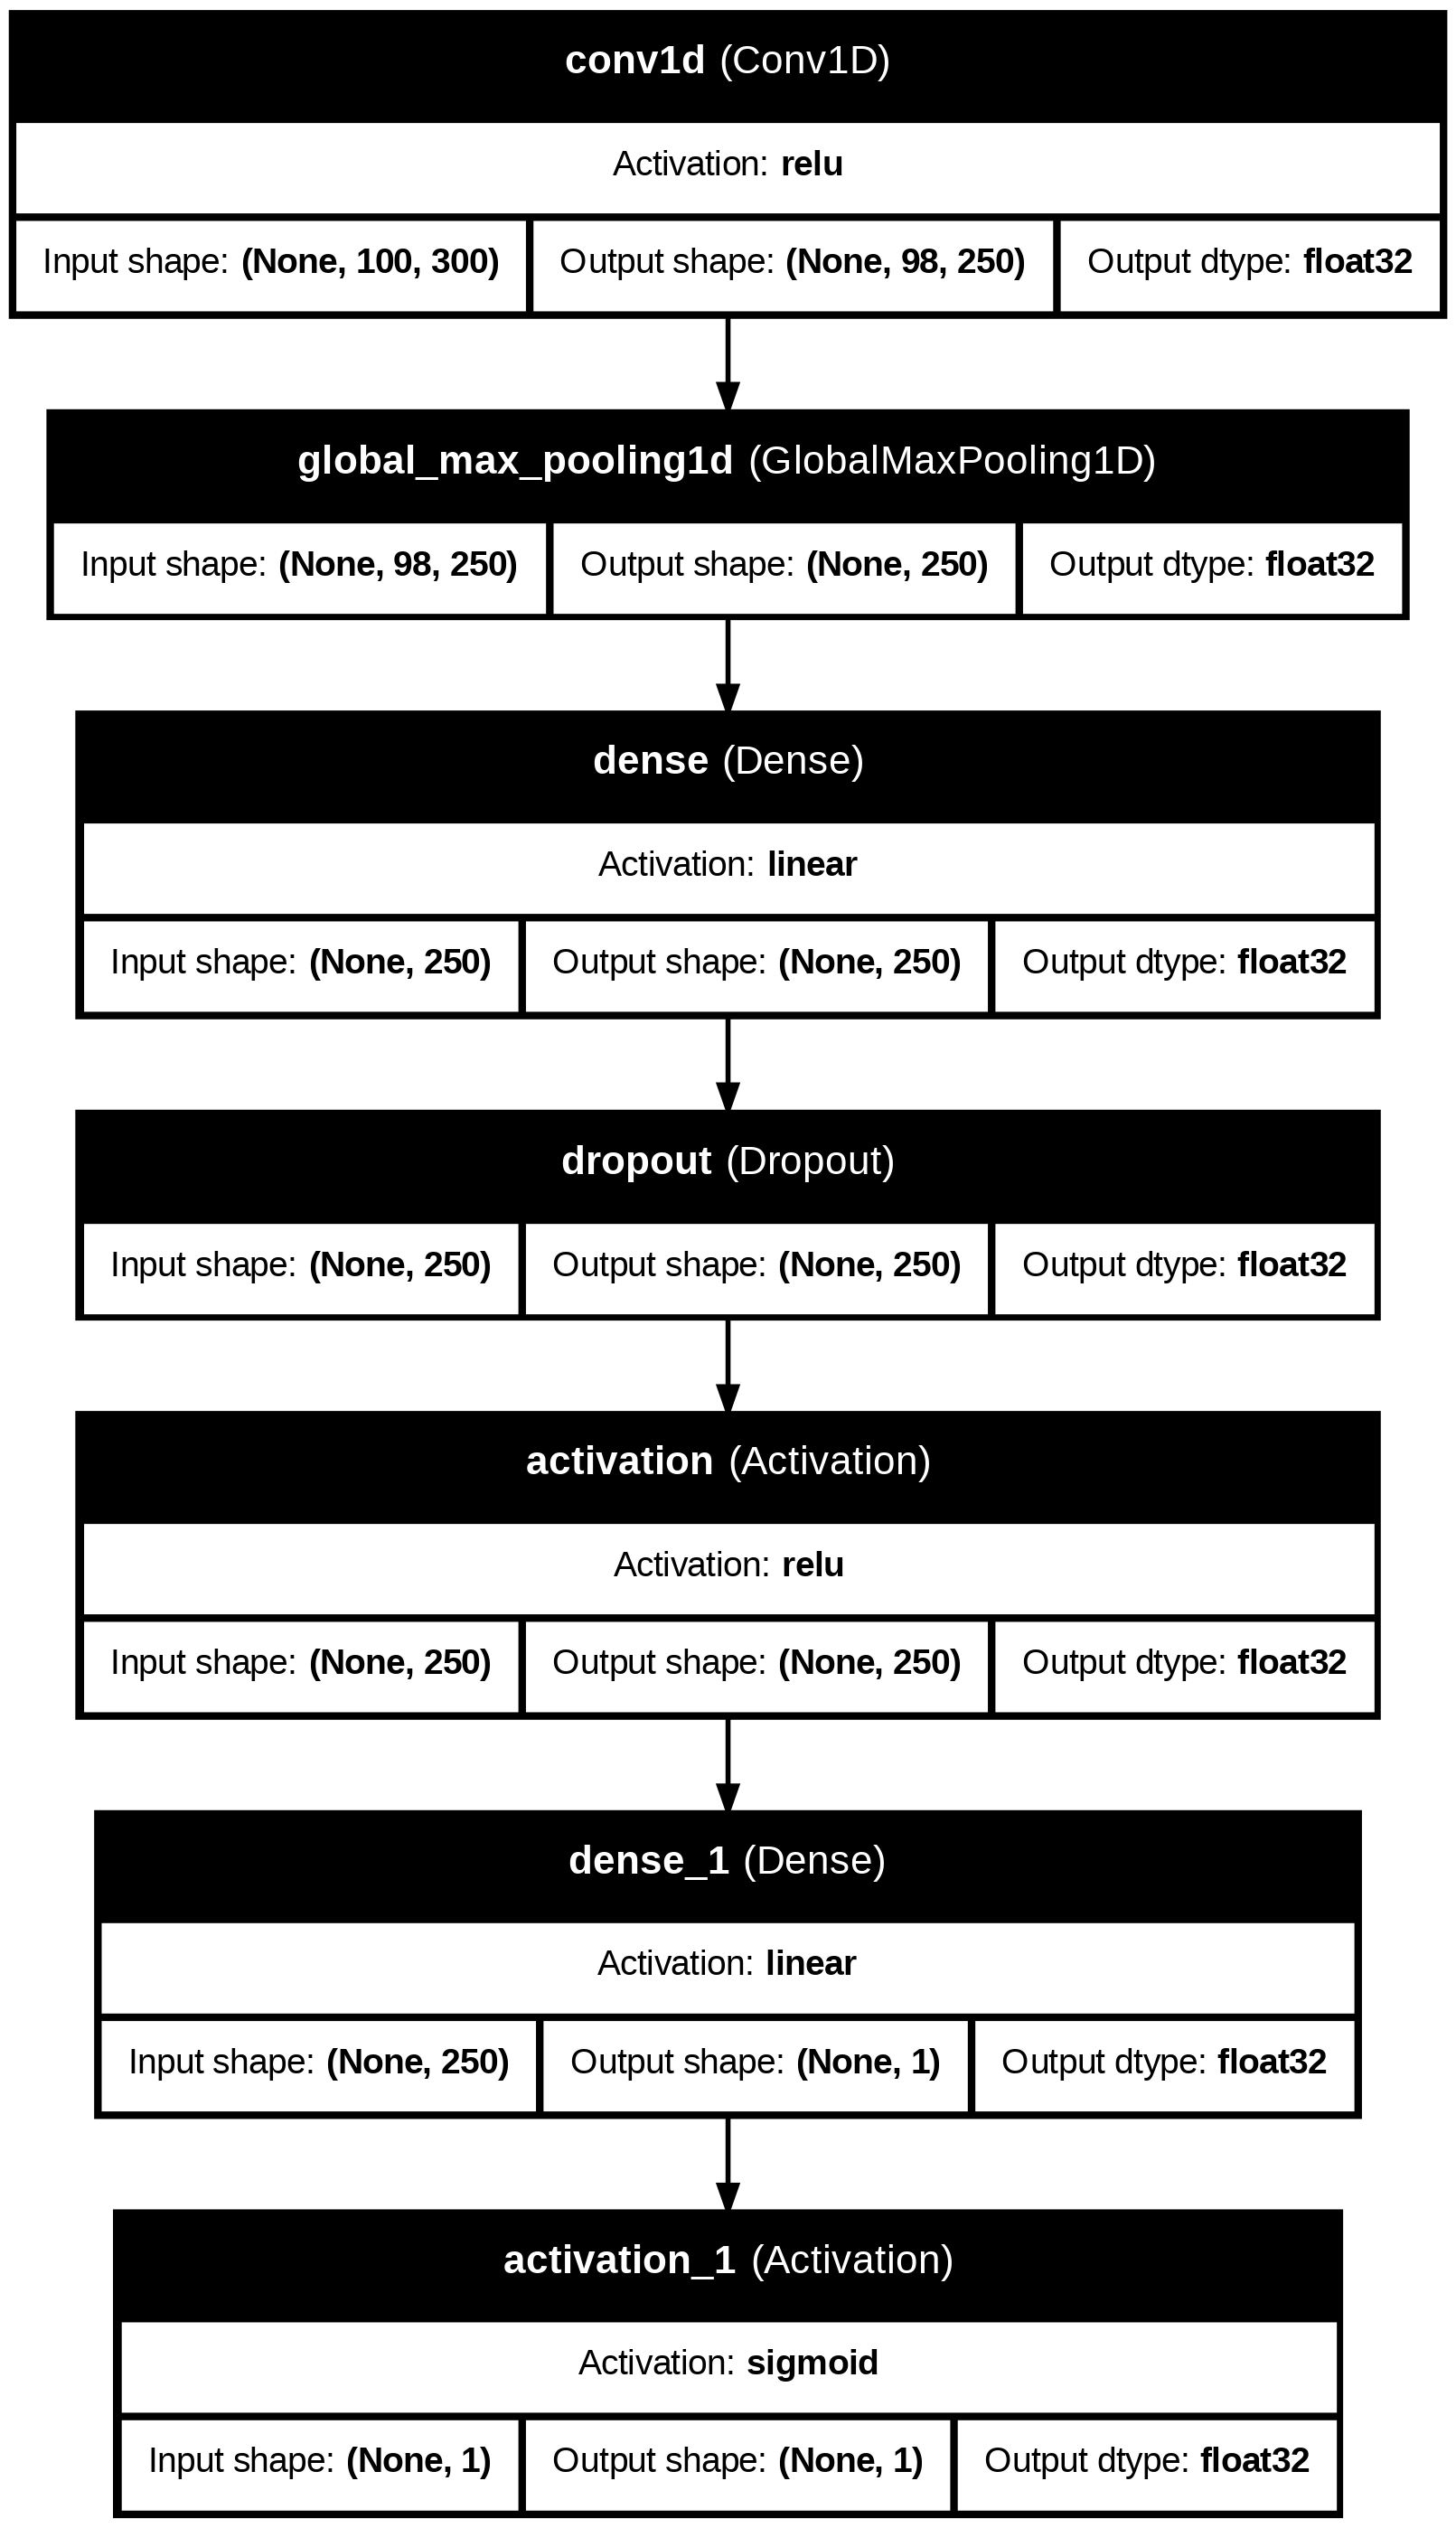

In [30]:
# Access the visualizer
from tensorflow.keras.utils import plot_model

# Now, behold your network
plot_model(model, show_shapes=True, show_layer_names=True, show_layer_activations=True, show_dtype=True)

There are several ways of tweaking the learning process by changing **hyperparameters** such as the **learning rate**. The values used for these are typically part of experiments and experience and if an engineer was not satisfied with the performance of their network they would adapt these to see if they could improve the results. For the purposes of demonstrating CNN in NLP, we will however stick to the defaults provided by Keras, which themselves are derived from experience.

(There are some great tools for monitoring and improving networks during training. **Tensorboard** facilitates this, see [this example](https://www.tensorflow.org/text/guide/word_embeddings))

In [31]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test))

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.7021 - loss: 0.5443 - val_accuracy: 0.8208 - val_loss: 0.3869
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8588 - loss: 0.3266 - val_accuracy: 0.8248 - val_loss: 0.3744


## Saving and reloading your model
**You** can and should save your expensively trained model as follows, so that you don't have to retrain every time you want to use it.

In [33]:
model_structure = model.to_json()
with open("cnn_model.json", "w") as json_file:
    json_file.write(model_structure)
model.save_weights("cnn.weights.h5")

You can then reload it (don't run this code unless you are reloading)

In [34]:
# Import the module to read in a JSON format model

from keras.models import model_from_json

# Now instantiate a model

with open("cnn_model.json", "r") as json_file:
  json_string = json_file.read()
model = model_from_json(json_string)

# Once the model structure exists, set its characteristic weights

model.load_weights('cnn.weights.h5')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 98, 250)             │         225,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 250)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 250)                 │          62,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 250)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             251 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 864,755 (3.30 MB)

 Trainable params: 288,251 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 576,504 (2.20 MB)

# Analyze sentiments!
At last, we have a sentiment analyzer that has taken the concept of pattern analysis used in image processing and extended it to natural language. So how did it do? Let's test it by making a few test inputs and seeing what happens.

In [35]:
sample_1 ="This is so cool! I am learning so much! I have only been working with natural language processing for a short while and now I am very happy that I can do so much after such a short amount of time. This is good knowledge and I am so glad that I am learning it"
sample_2 ="This is one of the worst movies I have ever seen. I am surprised anyone has recommended it, it is as bad as they get."
sample_3 ="This has been a truly awful week and I am exhausted and I just want to die. I really wish I didn't feel this bad. I am so sad."
# Play with some of the terms and see what happens
sample_4 = sample_3.replace("sad","happy")


Now,


* Take one of the samples
* **Tokenize** and **vectorize** it
* Convert the input to a **fixed input length** by **padding** or **truncating**
* Input it to the model for **prediction**
* **Present** the prediction



In [36]:
vec_list = tokenize_and_vectorize([(1, sample_2)]) # Feed a sample to the tokenizer and vectorizer

test_vec_list = pad_trunc(vec_list, maxlen) # convert the input to a fixed input length
test_vec = np.reshape(test_vec_list, (len(test_vec_list), maxlen, embedding_dims))

model.predict(test_vec) # predict the sentiment of the input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step


array([[0.04562911]], dtype=float32)

So, **sample_2** gives an output prediction very close to **0**, so it appears, correctly, to be **very negative**.

**Note that this is a sentence that the system has never seen before!**

## Disadvantages of CNNs for NLP

Also, what disadvantages did we see?
*  **Limited** window size
*  **Fixed** "sentence" sizes (one size fits none?)
* Exploitation of word **proximities** but no exploitation of **order**
* Worse, some sentences that have the ***same words but different orders*** have **opposite meanings**, but to a CNN these would appear the same, e.g. "*The vampire hunted the innocent.*" and "*The innocent hunted the vampire.*"

